In [22]:
import tensorflow as tf
import numpy as np
import itertools
import h5py as h5
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [2]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score

In [3]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras import initializers, optimizers
from keras.layers import Input, BatchNormalization
from keras.layers import  Dense, Flatten, Activation, Dropout, Embedding
from keras.layers import LSTM, TimeDistributed, Permute,Reshape, Lambda, RepeatVector, merge, Input,Multiply
from keras.utils import np_utils
from keras.layers.wrappers import  Bidirectional
from keras.layers import *
from keras import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2 
from keras.models import load_model
import keras

Using TensorFlow backend.


In [4]:
from os import listdir
from os.path import isfile, join
import glob
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [5]:
mypath = '/home/chenming/ncrna/ncRDeep/Data_Processing/Ten_Fold_Onehot_Data_h5/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [6]:
my_files8 = glob.glob("/home/chenming/ncrna/ncRDeep/Data_Processing/Ten_Fold_Onehot_Data_h5/Onehot*.h5")
my_files8.sort()
my_files8[0:2]

['/home/chenming/ncrna/ncRDeep/Data_Processing/Ten_Fold_Onehot_Data_h5/Onehot_Fold_0_Test_Data_750.h5',
 '/home/chenming/ncrna/ncRDeep/Data_Processing/Ten_Fold_Onehot_Data_h5/Onehot_Fold_0_Train_Data_750.h5']

In [7]:
def get_file8(fold_no): #get train and test data from file by fold number
    hf_Train = h5.File(my_files8[fold_no*2+1],'r')
    hf_Test = h5.File(my_files8[fold_no*2],'r')
    X_train = hf_Train['Train_Data'] # Get train set
    X_train = np.array(X_train)
    Y_train = hf_Train['Label']      # Get train label
    Y_train = np.array(Y_train)
    X_test = hf_Test['Test_Data']     # Get test set
    X_test = np.array(X_test)
    Y_test = hf_Test['Label']       # Get test label
    Y_test = np.array(Y_test)
    Y_train = np_utils.to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = np_utils.to_categorical(Y_test, 13)    #  Process the label of test
    return X_train, Y_train, X_test, Y_test

In [8]:
class_names = ['5S_rRNA', '5.8S_rRNA', 'tRNA', 'ribozymes', 'CD-box', 'miRNA', 'Intron_gpI', 'Intron_gpII', 'HACA-box', 'riboswitch', 'IRES', 'leader', 'scaRNA']
class_names

['5S_rRNA',
 '5.8S_rRNA',
 'tRNA',
 'ribozymes',
 'CD-box',
 'miRNA',
 'Intron_gpI',
 'Intron_gpII',
 'HACA-box',
 'riboswitch',
 'IRES',
 'leader',
 'scaRNA']

In [9]:
def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    FONT_SIZE = 10
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix\n============================")
    else:
        #cm = np.asfarray(cm,float64)
        print('Confusion matrix, without normalization\n============================')
    #print(cm)
    plt.figure(figsize=(5*2, 4*2))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=FONT_SIZE)
    plt.yticks(tick_marks, classes, fontsize=FONT_SIZE)
    fmt = '.3f' if normalize else '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    fontsize=FONT_SIZE,
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize=FONT_SIZE)
    plt.xlabel('Predicted label', fontsize=FONT_SIZE)
    plt.savefig('Conf_mat_avg.pdf')
    plt.show()

In [10]:
def Conv1Dme(f, k, x):
    x1=Conv1D(filters=f,kernel_size=k,strides=1,padding="same",kernel_initializer=initializers.random_uniform()) (x)
    x1 = BatchNormalization()(x1)
    x1=Dropout(0.2)(x1)
    x1=LeakyReLU(alpha=0.3)(x1)
    #x1=MaxPooling1D(pool_size=2, strides=2)(x1)
    return x1

In [11]:
def dense_block_1(xin, f, k, p):
    f1 = f
    k1 = k
    p1 = p

    x1 = Conv1Dme(f1, k1, xin)
    x11 = Conv1Dme(f1, k1, x1)
    x11 = Concatenate(axis=-1)([x1,x11])
    x11 = Conv1Dme(f1, k1, x11)
    x11 = Concatenate(axis=-1)([x1,x11])
    x11 = Conv1Dme(f1, k1, x11)
    x1=MaxPooling1D(pool_size=p1, strides=p1)(x11)
    
    return x1

In [12]:
def fc_block_1(xin, n):
    xf=Dense(n,)(xin)
    xf = BatchNormalization()(xf)
    xf=Dropout(0.2)(xf)
    xf=LeakyReLU(alpha=0.3)(xf)
    return xf

In [13]:
def model_dense3(): # Model
    inputs1 = Input(shape=(750, 4))
    
    ###############################################################
    #          First block conv
    
    x1 = Conv1Dme(64, 5, inputs1)
    x1 = MaxPooling1D(pool_size=2, strides=2)(x1)
    #x1 = inputs1
    
    ###############################################################
    #          Dense block
    
    x1 = dense_block_1(x1, 128, 5, 4)
    x1 = dense_block_1(x1, 128, 5, 4)
    #x1 = dense_block_1(x1, 256, 5, 2)
    #x1 = dense_block_1(x1, 256, 5, 4)
    x1 = Conv1Dme(128, 5, x1)
    x1 = MaxPooling1D(pool_size=2, strides=2)(x1)
       
    ###############################################################
    #          FC block
    
    xf=Flatten()(x1)
    
    xf = fc_block_1(xf, 256)
    xf = fc_block_1(xf, 64)

    xf=Dense(13, activation='softmax',  )(xf)

    model = Model(inputs=inputs1, outputs=xf)

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0005),metrics=['accuracy'])
    
    return model

In [14]:
hf_Test = h5.File('/home/chenming/ncrna/ncRDeep2/Data_Processing/testdata.h5','r')
X_val = hf_Test['Test_Data']      # Get train label
X_val = np.array(X_val)
Y_val = hf_Test['Label']       # Get test label
Y_val = np.array(Y_val)
Y_val = np_utils.to_categorical(Y_val, 13)

In [36]:
auc_mat_750c1 = []
history_750c1 = []
conf_mat_750c1 = []
history_750c1 = {}
class_report_750c1 = {}
for i in range(0,10):
    X_train, Y_train, X_test, Y_test = get_file8(i)
    model = model_dense3()
    #es = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
    #history = model.fit(X_train[:,:,0:4], Y_train, validation_data=(X_test[:,:,0:4], Y_test), epochs=100, verbose=0, callbacks=[es])
    #model.save_weights("Checkpoints/Reviewlast_onehot_fold_%i.h5" %i)
    model.load_weights("Checkpoints/Reviewlast_onehot_fold_%i.h5" %i)
    y = model.predict(X_val[:,:,0:4])
    y_test_non_category = [ np.argmax(t) for t in Y_val ]
    y_predict_non_category = [ np.argmax(t) for t in y ]
    auc = accuracy_score(y_test_non_category, y_predict_non_category)
    precision,recall,fscore,support=score(y_test_non_category, y_predict_non_category,average='macro')
    mcc = matthews_corrcoef(y_test_non_category, y_predict_non_category)
    conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
    classification_reports = classification_report(y_test_non_category, y_predict_non_category)
    print(i,auc,recall,precision,fscore,mcc)
    auc_mat_750c1.append([[auc],[recall],[precision],[fscore],[mcc]])
    #history_5.append([history.history])
    #history_750c1['fold%i'%i]=history.history
    conf_mat_750c1.append([conf_mat])
    class_report_750c1['fold%i'%i]=classification_reports

(0, 0.9465384615384616, 0.9465384615384616, 0.9486335992657641, 0.946835563922504, 0.9422127454775299)
(1, 0.943076923076923, 0.9430769230769229, 0.9451694263410927, 0.9432631750264744, 0.9384784778475589)
(2, 0.9488461538461539, 0.9488461538461537, 0.9511869105586678, 0.9491645545066562, 0.9447298989560021)
(3, 0.9376923076923077, 0.9376923076923076, 0.9389144438547182, 0.9376076035483949, 0.9326188267955069)
(4, 0.9403846153846154, 0.9403846153846153, 0.9424456059609905, 0.9408065509072655, 0.9355228185473444)
(5, 0.9465384615384616, 0.9465384615384616, 0.9503883599062966, 0.9473205245761858, 0.9423139566529268)
(6, 0.9296153846153846, 0.9296153846153847, 0.9334833251751818, 0.9303871534938412, 0.9239580620604569)
(7, 0.9411538461538461, 0.9411538461538461, 0.9546836856080267, 0.9439480375321063, 0.9372552346274887)
(8, 0.9315384615384615, 0.9315384615384615, 0.9335686554465699, 0.9322009023360545, 0.9258944681274122)
(9, 0.9442307692307692, 0.9442307692307691, 0.9453992116241026, 0.

In [37]:
auc_mat_750c1 = np.array(auc_mat_750c1)
for i in range(5):    
    print(np.average(auc_mat_750c1[:,i]))

0.9409615384615385
0.9409615384615384
0.9443873223741411
0.9415795676739546
0.9362659234335051


In [38]:
np.std(auc_mat_750c1[:,0], ddof=1)

0.006395495826275346

In [39]:
len(conf_mat_750c1)

10

Confusion matrix, without normalization


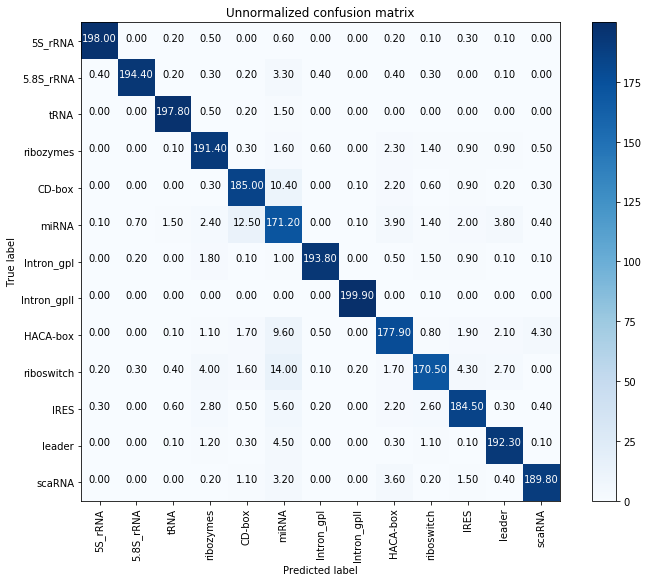

In [40]:
conf_mat_750s = np.array(conf_mat_750c1)
conf_mat_sum = conf_mat_750s[0,0,:,:]
for i in range(1,10):
    conf_mat_sum = conf_mat_sum + conf_mat_750s[i,0,:,:]
conf_mat_avg = np.true_divide(conf_mat_sum,10)
conf_mat_avg.dtype
plot_confusion_matrix(conf_mat_avg, classes=class_names, normalize=False,
                        title='Unnormalized confusion matrix')

Normalized confusion matrix


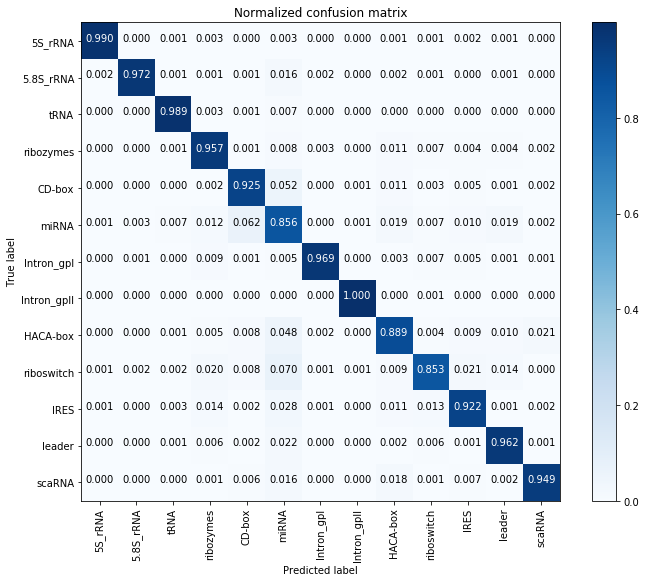

In [41]:
plot_confusion_matrix(conf_mat_avg, classes=class_names, normalize=True,
                        title='Normalized confusion matrix')